In [1]:
import pandas as pd
import pingouin as pg
import numpy as np
from math import ceil
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from glob import glob
import os
from plotting.plot import pretty_behav_plot

%load_ext autoreload
%autoreload 2

/home/predatt/giaald/.conda/envs/giacomo37/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/home/predatt/giaald/.conda/envs/giacomo37/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


## Behavioral data

In [2]:
allsubjdirs = sorted(glob('../../bids/sub-*'))
subjlist = [f'sub-{s:03d}' for s in range(1, 36)] #if s != 6]
allsubjs_trials = pd.DataFrame()
for i, s in enumerate(subjlist):
    behfile = glob(os.path.join('../../bids', s, 'func', '*beh.tsv'))[0]
    behav = pd.read_csv(behfile, sep='\t')
    behav.insert(0, 'Subject', i + 1)
    allsubjs_trials = pd.concat([allsubjs_trials, behav])

In [3]:
allsubjs_trials

,Subject,Scene,InitView,FinalView,Diff,Orients_1,Orients_2,Consistent,Hit,RT,Sequence_1,Sequence_2,Sequence_3,Sequence_4,Sequence_5,Jitter,Fix
0,1,7,1,90,5.0,0,5.0,1,1.0,0.763023,0,15,30,45,90,152,148
1,1,3,2,30,5.0,0,5.0,1,1.0,0.706215,0,15,20,25,30,129,171
2,1,13,2,30,-5.0,-2,-7.0,0,1.0,0.783116,0,15,20,25,30,145,155
3,1,20,2,90,-4.5,0,-4.5,1,1.0,1.191430,0,30,45,50,90,176,124
4,1,13,2,90,-4.0,-1,-5.0,1,0.0,1.267132,0,20,45,55,90,168,132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,35,4,1,30,0.5,0,0.5,1,1.0,0.526852,0,15,20,25,30,126,174
332,35,9,1,90,0.5,-2,-1.5,1,1.0,0.891972,0,20,30,50,90,127,173
333,35,8,1,30,0.5,2,2.5,1,1.0,0.900208,0,15,20,25,30,139,161
334,35,13,2,30,-0.5,1,0.5,1,1.0,0.426043,0,15,20,25,30,159,141


## Plot staircases

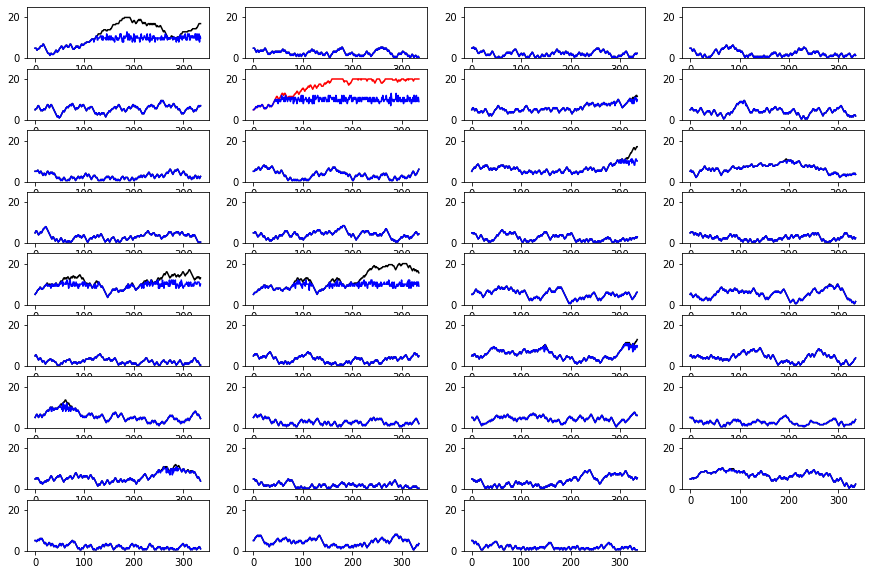

In [4]:
n_missed = []
remove_subjs = []
fig = plt.figure(figsize=(15,10))
nsubjs = len(allsubjs_trials.Subject.unique())
for s in allsubjs_trials.Subject.unique():
    thisstair = np.array(abs(allsubjs_trials.loc[allsubjs_trials['Subject'] == s]['Diff']))
    realstair = abs(allsubjs_trials[allsubjs_trials['Subject']==s].Orients_1.values - 
                   allsubjs_trials[allsubjs_trials['Subject']==s].Orients_2.values)
    theseresps = np.array(allsubjs_trials.loc[allsubjs_trials['Subject'] == s]['Hit'])
    howmuchceil = sum(thisstair==20)
    missingtrials = np.count_nonzero(np.isnan(theseresps))
    n_missed.append(missingtrials)
    ax = fig.add_subplot(ceil(nsubjs/4), 4, s)
    ax.set_ylim([0, 25])
    k = np.nansum(theseresps)
    n = len(thisstair)
    #if binom_test(k, n, p=0.5, alternative='greater')>0.05:
    if howmuchceil >= len(thisstair)/20 or missingtrials >= len(thisstair)/3:
        #print(k/n)
        ax.plot(thisstair, 'r')
        remove_subjs.append(s)
    else:
        ax.plot(thisstair, 'k')
    ax.plot(realstair, 'b')

In [5]:
# Which participants to remove
remove_subjs

[6]

In [6]:
allsubjs_trials = allsubjs_trials[~allsubjs_trials['Subject'].isin(remove_subjs)]

## Expected vs Unexpected t-test

In [7]:
allsubj_means = allsubjs_trials.groupby(['Subject', 'Consistent']).mean().reset_index()

In [8]:
pg.ttest(allsubj_means[allsubj_means['Consistent']==1]['Hit'], 
         allsubj_means[allsubj_means['Consistent']==0]['Hit'], paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.830773,33,two-sided,0.007848,"[0.01, 0.06]",0.690969,5.307,0.974367


## Plot

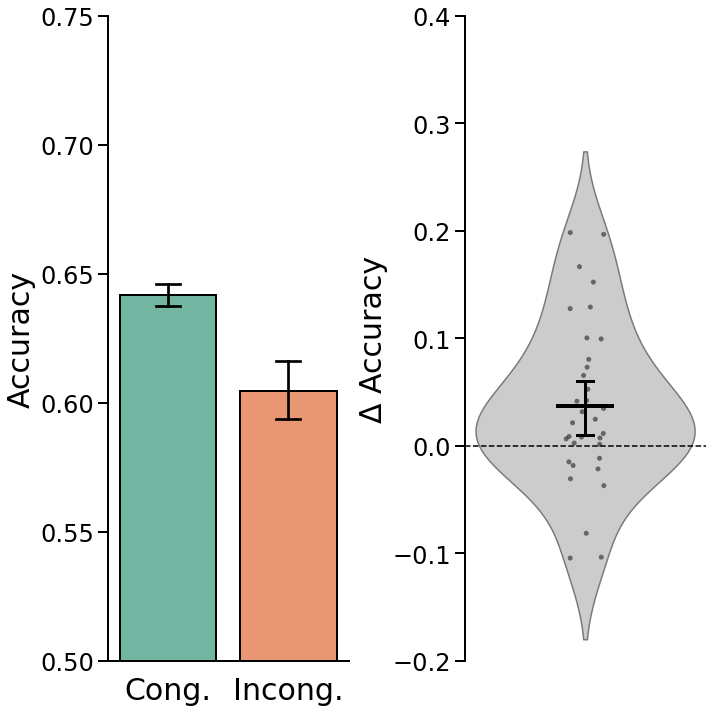

In [12]:
pretty_behav_plot(allsubj_means, saveimg=True)

In [ ]:
# Get all differences
alldiffs = []
for sub in allsubj_means.Subject.unique():
    thisdiff = allsubj_means[(allsubj_means.Subject==sub)&(allsubj_means.Consistent==1)].Hit.values[0]-\
               allsubj_means[(allsubj_means.Subject==sub)&(allsubj_means.Consistent==0)].Hit.values[0]
    alldiffs.append({'Subject': sub, 'Difference': thisdiff})
alldiffs = pd.DataFrame(alldiffs)

In [ ]:
fig = plt.figure(figsize=(10,8))
gs = GridSpec(1, 2, figure=fig)
with sns.axes_style('white'):
    #ax0 = fig.add_subplot(121)
    ax0 = fig.add_subplot(gs[0, :-1])
    sns.barplot(x='Consistent', y='Hit', data=allsubj_means, ci=68, order=[1.0, 0.0], palette='Set2', ax=ax0)
    ax0.set_ylabel('Hit rate', fontsize=24)
    plt.yticks(fontsize=20) 
    ax0.set_xlabel(None)
    ax0.set_xticklabels(['Expected', 'Unexpected'], fontsize=20)
    ax0.set(ylim=(0.5, 0.75))
    ax0.spines['top'].set_visible(False)
    ax0.spines['right'].set_visible(False)
with sns.axes_style('white'):
    #ax1 = fig.add_subplot(122)
    ax1 = fig.add_subplot(gs[0, -1])
    sns.violinplot(y='Difference', data=alldiffs, color=".8", inner=None)
    sns.stripplot(y='Difference', data=alldiffs, jitter=0.07, ax=ax1, color='black', alpha=.5)
    # Get mean and 95% CI:
    meandiff = alldiffs['Difference'].mean()
    tstats = pg.ttest(alldiffs['Difference'], 0.0)
    ci95 = tstats['CI95%'][0]
    #plt.gca().set_aspect('equal')
    #ax1.axis('equal')
    for tick in ax1.get_xticks():
        ax1.plot([tick-0.1, tick+0.1], [meandiff, meandiff],
                    lw=4, color='k')
        ax1.plot([tick, tick], [ci95[0], ci95[1]], lw=3, color='k')
        ax1.plot([tick-0.01, tick+0.01], [ci95[0], ci95[0]], lw=3, color='k')
        ax1.plot([tick-0.01, tick+0.01], [ci95[1], ci95[1]], lw=3, color='k')
        #circlemarker = matplotlib.patches.Ellipse((tick+0.0032, meandiff), 0.06, 0.02, color='k')
        #ax1.add_patch(circlemarker)
    ax1.axhline(0.0, linestyle='--', color='black')
    plt.yticks(fontsize=20) 
    ax1.set_ylabel('Δ Hit rate', fontsize=24)
    ax1.set(ylim=(-0.2, 0.4))
    ax1.axes_style = 'white'
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
plt.tight_layout()
#plt.savefig('Plots/Behav_acc.pdf')

## Demographic information

In [ ]:
particfile = '../../bids/participants.tsv'
particinfo = pd.read_csv(particfile, sep='\t')

In [ ]:
particinfo = particinfo[particinfo.participant_id!='sub-006']

In [ ]:
particinfo.age.agg(['mean', 'std'])

In [ ]:
particinfo.sex.value_counts()